## Usecase: Predicting pedestrian numbers in Melbourne CBD
<hr>
<b>Applying Time Series methods to predict pedestrian numbers using the City of Melbourne's network of pedestrain sensors.</b>


This use case will explore different methods for predictive modelling with a time series. It will begin with importing data from the pedestrian sensor network. For simplicity, we'll just focus on one sensor, the one near the Town Hall.

These are the methods we will be using for time series analysis in this use case:<br>
<list>
* Naive approach to establish a baseline
* LSTM - univariate
* LSTM - multivariate
* GRU
* GRU/LSTM hybrid
* Random Forest Regression
* TBATS
* SARIMAX
</list>

It is reasonable to assume that external factors can influence the number of pedestrians walking past a sensor at any particular time. So we are going to find some other datasets which look like they could be relevant, and we will incorporate them into our modelling to see if we can improve our results. These datasets will include:<br>
<list>
* Microclimate sensor data
* Event data
* Rainfall data
* Lockdown data
* Holiday data
</list>


In [1]:
#Import all required packages

from math import sqrt
from numpy import concatenate
import numpy as np
from numpy import array

import keras
from keras.models import Sequential
from keras.layers import LSTM, BatchNormalization, GRU
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.utils import to_categorical
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
import tensorflow as tf

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot as plt
# from sodapy import Socrata

import time
from datetime import datetime

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tbats import BATS, TBATS


## Import pedestrian sensor data.
<hr>
For this example, we will begin by grabbing the dataset. We'll only look at one of the sensors to begin with. This dataset is pretty big, so we have written code below to save it as a csv file once it is downloaded and to store is locally.

In [2]:
# # Uncomment the below to open data source, download sensor data, and store it as a csv locally.

# #Function to get Sensor count history data
# def sensor_count():
#     client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
#     sensor_data_id = "b2ak-trbp"
#     results = client.get(sensor_data_id, limit=5000000)
#     df = pd.DataFrame.from_records(results)
#     df = df[['date_time', 'year', 'month', 'mdate', 'day', 'time', 'sensor_id', 'sensor_name', 'hourly_counts']]
#     return df

# sensor_history = sensor_count()

# sensor_history.to_csv('sensor_history.csv', index=False)

In [3]:
sensor_history = pd.read_csv('sensor_history.csv')

In [4]:
single_sensor = sensor_history[sensor_history.sensor_id == 4].copy()
single_sensor.sort_values('date_time', inplace=True, ascending=True)

<b>Let's do a quick visualisation:</b>

We create a quick chart here, with the date on the x-axis, and the hourly counts on the y-axis.

There are a few immediate observations: 
Firstly, there is a missing chunk of data around the year 2017.
Secondly, the overall pattern has some dramatic changes in early 2020, coinciding with the arrival of Covid-19.
Thirdly there are some potential outliers, for example an hourly count of 8000 in the year 2010.

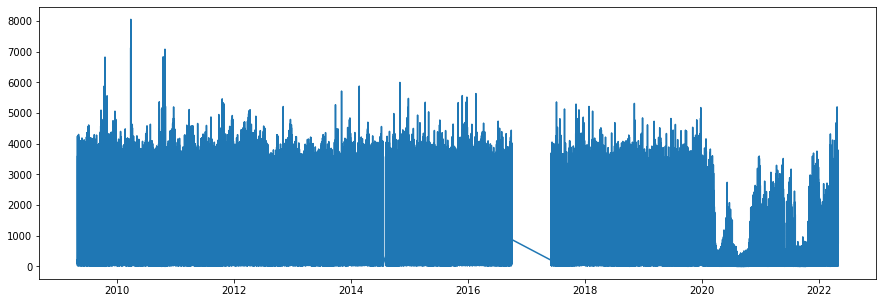

In [5]:
subset = single_sensor[['date_time', 'hourly_counts']].copy()
subset.date_time = pd.to_datetime(subset.date_time)
plt.figure(figsize = (15, 5))
plt.plot(subset.date_time, subset.hourly_counts)

<b>Use a Naive approach to create a baseline:</b>

Now, it is important to understand that a model that attempts to make predictions on a time series can have reasonably good success by simply copying the value of the previous time step. In most cases, this value will be close to the next value in the sequence - and this can give the appearance of predictive ability where there is actually none.

For example, if a sensor has 100 pedestrians recorded between 2am to 3am, then it is likely that the number of pedestrians recorded between 3am and 4am won't be too much more or less than 100. So a model that simply predicted '100' in this case would have reasonable accuracy. 

So before building models and evaluating them, it is worthwhile setting up a baseline. This is the performance attained by simply copying the hourly count from the previous time step.

In [6]:
true_count = single_sensor.hourly_counts.to_numpy()
prev_count = true_count[1:true_count.shape[0]]
r2_baseline = r2_score(prev_count, true_count[0:true_count.shape[0]-1])   
print("The baseline R-squared score is:", r2_baseline)

The baseline R-squared score is: 0.8835439180056677


From this example we can see a fairly convincing score (at the time of writing this comment, it was around 0.884). However, we know that the model we just made is useless for our purposes.
We need to improve on this score!

<b>Preparing the data:</b>

The first thing we will do is a simple kind of scaling on the 'hourly_counts'. Later, when we look at multivariate LSTM, we will use different methods of scaling the data.

In [7]:
#Make sensor counts range from 0 to 1.
maximum = single_sensor.hourly_counts.max()
single_sensor['hourly_counts'] = single_sensor['hourly_counts']/maximum

In [8]:
sensor_seq = []
for i in range(0, len(single_sensor)):
    sensor_seq.append(single_sensor.hourly_counts.iloc[i])

In [9]:
#This code is copied almost verbatim from the website 'Machine Learning Mastery'
#which is ne of my favourite sites to learn about machine learning!

# split a univariate sequence
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# choose a number of time steps
n_steps = 168
# split into samples
X, y = split_sequence(sensor_seq, n_steps)


In [10]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

These next three chunks of code use different sections of the dataset.
Using the whole dataset takes much longer to train.
Using the earliest sections means using data unaffected by coronavirus. This may be
more accurate in the long run.
Using the latest sections means using data affected by coronavirus. This may be more
accurate while coronavirus is still having an impact.

In [11]:
#This next code will split the entire dataset. In practice, this took a long time to train.

# X_train = X[10001:80000]
# X_val = X[80001:]
# X_test = X[:10000]
# Y_train = y[10001:80000]
# Y_val = y[80001:]
# Y_test = y[:10000]

#This uses a subset of the dataset, from near the beginning of the time series.

# X_train = X[15001:25000]
# X_val = X[25001:30000]
# X_test = X[5000:10000]
# Y_train = y[15001:25000]
# Y_val = y[25001:30000]
# Y_test = y[5000:10000]

#This uses a subset of the dataset, from near the end of the time series.

X_train = X[85001:105000]
X_val = X[75001:85000]
X_test = X[65000:75000]
Y_train = y[85001:105000]
Y_val = y[75001:85000]
Y_test = y[65000:75000]

<b>Build our first model</b>

Here we build our first model - our univariate LSTM model. It is called univariate because it only uses one variable: the hourly count of pedestrians.<br>

In [12]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(48, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(96, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=opt, loss='mse')

In [13]:
# fit model
history = model.fit(X_train, Y_train, validation_data =(X_val, Y_val), epochs=50, verbose=0, batch_size = 64)

Let's have a look at how the training went. From the chart below we can see that there was no overfitting. In fact, if we added more epochs we could improve the model even further - however it would take a long time to produce even minimal gains.<br>

Increasing the learning rate could make this model converge faster.

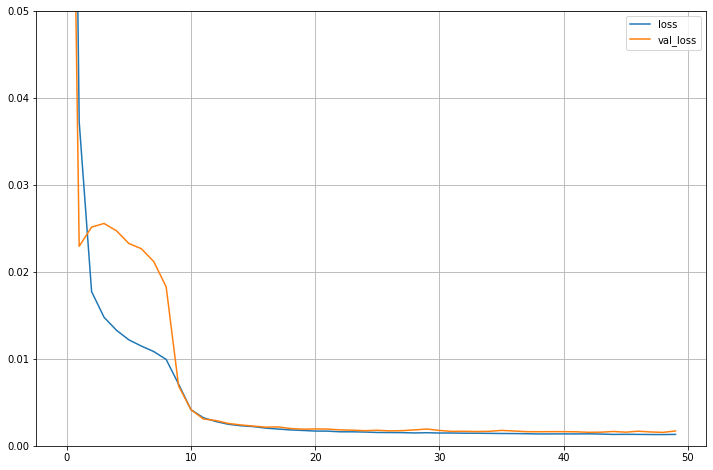

In [14]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0, 0.05)
plt.show()

In [15]:
# demonstrate prediction
x_input = array(sensor_seq[1001:1001+n_steps])

x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print("predicted next value: ", yhat  * maximum)
print("actual next value: ", sensor_seq[1001+n_steps] * maximum)

predicted next value:  [[3048.15]]
actual next value:  3115.0


In [16]:
# demonstrate prediction
x_input = array(sensor_seq[80001:80001+n_steps])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print("predicted next value: ", yhat  * maximum)
print("actual next value: ", sensor_seq[80001+n_steps] * maximum)

predicted next value:  [[3245.8987]]
actual next value:  3338.0


In [17]:
pred = model.predict(X_test)
first_score = r2_score(Y_test, pred)
print("The first R-squared score we have attained is:", first_score)

313/313 [==============================] - 10s 31ms/step
The first R-squared score we have attained is: 0.9221161848011334


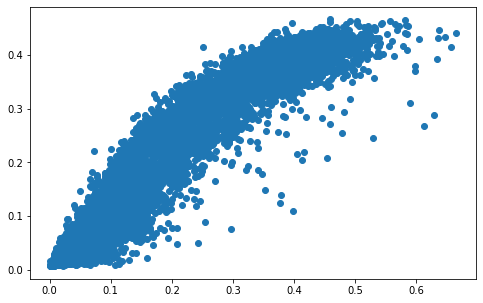

In [18]:
#Now let us visualise the predicted values against the actual values:
plt.figure(figsize=(8,5))
plt.scatter(Y_test, pred)
plt.show()

In [19]:
#Grab a random day and do a 24 hour prediction, and compare it to the actual values

pred = np.zeros((24), dtype=int)

for i in range (0, len(pred)):
    x = array(sensor_seq[i + 104996:i + 104996 + n_steps])
    x = x.reshape((1, n_steps, n_features))
    inc_pred = model.predict(x, verbose=0)
    pred[i] = inc_pred * maximum

actual = subset.iloc[104996:105021]
actual = actual.to_numpy()

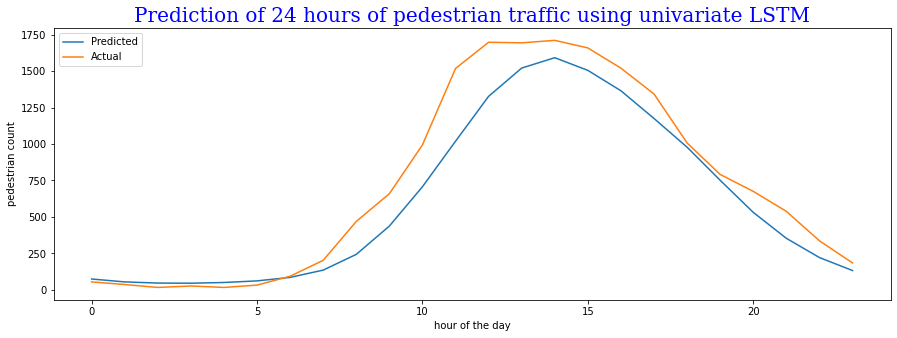

In [20]:
font1 = {'family':'serif','color':'blue','size':20}

plt.figure(figsize = (15, 5))
plt.title("Prediction of 24 hours of pedestrian traffic using univariate LSTM", fontdict = font1)
plt.xlabel('hour of the day')
plt.ylabel('pedestrian count')

plt.plot(pred, label = 'Predicted')
plt.plot(actual[0:24,1], label = 'Actual')
plt.legend(loc="upper left")

In [21]:
#Save the model:
# model.save("LSTM_univariate.h5")

##### In this section, we will look at adding different datasets and performing mulitvariate LSTM

In [22]:
# #Function to get Sensor count history data
# def micro_count():
#     client = Socrata('data.melbourne.vic.gov.au', 'nlPM0PQJSjzCsbVqntjPvjB1f', None)
#     micro_data_id = "u4vh-84j8"
#     results = client.get(micro_data_id, limit=4000000)
#     if results:
#         df = pd.DataFrame.from_records(results)
#     return df

# micro_history = micro_count()

# micro_history.to_csv('micro_history.csv', index=False)

In [23]:
micro_history = pd.read_csv('micro_history.csv')

micro_history = micro_history[(micro_history.sensor_id == '5a') | (micro_history.sensor_id == '5b') |
                             (micro_history.sensor_id == '5c') | (micro_history.sensor_id == '0a') |
                             (micro_history.sensor_id == '0b') | (micro_history.sensor_id == '6')]

micro_history = micro_history[(micro_history.site_id == 1003) | (micro_history.site_id == 1009)]

micro_history = micro_history.drop(['id', 'gateway_hub_id', 'type', 'units'], axis=1)

micro_history.loc[micro_history.sensor_id == '5a', 'temp'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '5b', 'humidity'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '5c', 'pressure'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '0a', 'part_2p5'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '0b', 'part_10'] = micro_history.value
micro_history.loc[micro_history.sensor_id == '6', 'wind'] = micro_history.value

micro_history.local_time = pd.to_datetime(micro_history.local_time, format='%Y-%m-%d')
micro_history['year'] = micro_history.local_time.dt.year
micro_history['month'] = micro_history.local_time.dt.month_name()
micro_history['mdate'] = micro_history.local_time.dt.day
micro_history['time'] = micro_history.local_time.dt.hour

micro_history = micro_history.drop(['site_id', 'sensor_id', 'value', 'local_time'], axis=1)
micro_history = micro_history.groupby(by=['year', 'month', 'mdate', 'time']).max()

ped_climate = sensor_history.merge(micro_history, on=('year', 'month', 'mdate', 'time'), how='inner')

In [24]:
single_sensor_climate = ped_climate.loc[ped_climate.sensor_name == 'Town Hall (West)'].copy()

In [25]:
single_sensor_climate.fillna(method='ffill', inplace = True)

In [26]:
single_sensor_climate.head()

,date_time,year,month,mdate,day,time,sensor_id,sensor_name,hourly_counts,temp,humidity,pressure,part_2p5,part_10,wind
512,2019-11-15T09:00:00.000,2019,November,15,Friday,9,4,Town Hall (West),1430,15.41,66.14,1008.0,4.5,18.4,7.92
567,2019-11-15T10:00:00.000,2019,November,15,Friday,10,4,Town Hall (West),2101,16.12,59.41,1008.0,4.2,20.0,7.88
622,2019-11-15T11:00:00.000,2019,November,15,Friday,11,4,Town Hall (West),2577,16.90,57.53,1007.9,4.1,20.1,7.92
677,2019-11-15T12:00:00.000,2019,November,15,Friday,12,4,Town Hall (West),3439,18.73,54.64,1007.5,4.5,23.1,9.68
732,2019-11-15T13:00:00.000,2019,November,15,Friday,13,4,Town Hall (West),4043,18.78,51.06,1006.7,4.1,18.7,10.44


In [27]:
single_sensor_climate.drop(['date_time', 'year', 'sensor_id', 'sensor_name', 'mdate'], axis = 1, inplace = True)

In [28]:
month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

In [29]:
single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [30]:
single_sensor_climate.head()

,month,day,time,hourly_counts,temp,humidity,pressure,part_2p5,part_10,wind
512,11,5,9,1430,15.41,66.14,1008.0,4.5,18.4,7.92
567,11,5,10,2101,16.12,59.41,1008.0,4.2,20.0,7.88
622,11,5,11,2577,16.90,57.53,1007.9,4.1,20.1,7.92
677,11,5,12,3439,18.73,54.64,1007.5,4.5,23.1,9.68
732,11,5,13,4043,18.78,51.06,1006.7,4.1,18.7,10.44


In [31]:
scaler = MinMaxScaler()

In [32]:
scaled = scaler.fit_transform(single_sensor_climate)

In [33]:
new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

In [34]:
for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:9] = scaled[i][0:9]
    new_sequence[i][10] = scaled[i+1][3]

In [35]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

In [36]:
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

In [37]:
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [38]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [39]:
model.fit(train_x, train_y, validation_data = (test_x, test_y), epochs=500, verbose=0, batch_size = 64)

In [40]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

89/89 [==============================] - 2s 8ms/step
R-squared score: 0.938


In [41]:
#Save the model:
# model.save("LSTM_multivariate_1.h5")

In [42]:
#What about if we try one hot encoding instead?
single_sensor_climate = ped_climate.loc[ped_climate.sensor_name == 'Town Hall (West)'].copy()
single_sensor_climate.fillna(method='ffill', inplace = True)

month_dummies = pd.get_dummies(single_sensor_climate.month)
day_dummies = pd.get_dummies(single_sensor_climate.day)

In [43]:
single_sensor_climate.drop(['date_time', 'month', 'day', 'year', 'sensor_id', 'sensor_name', 'mdate'], axis = 1, inplace = True)

In [44]:
single_sensor_climate = pd.concat([single_sensor_climate, month_dummies, day_dummies], axis = 1)

In [45]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(single_sensor_climate)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:26] = scaled[i][0:26]
    new_sequence[i][27] = scaled[i+1][1]  


In [46]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [47]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [48]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=0, batch_size = 64)

In [49]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

89/89 [==============================] - 2s 6ms/step
R-squared score: 0.919


##### That didn't improve the model. Let's try adding more datasets and see if we can improve things. 

In [50]:
#What about if we add more datasets?
combined = pd.read_csv('combined.csv')

In [51]:
combo_climate = ped_climate.merge(combined, on=('year', 'month', 'mdate', 'time', 'sensor_id',
                                                'day', 'sensor_name', 'hourly_counts'), how='inner')

In [52]:
single_sensor_climate = combo_climate.loc[combo_climate.sensor_name == 'Town Hall (West)'].copy()

month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [53]:
single_sensor_climate.drop(['date_time_x', 'date_time_y', 'year', 'sensor_id', 'sensor_name'
                            , 'lat', 'lon', 'sensor_description', 'mdate'], axis = 1, inplace = True)

In [54]:
single_sensor_climate.fillna(method='ffill', inplace = True)

In [55]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(single_sensor_climate)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:15] = scaled[i][0:15]
    new_sequence[i][16] = scaled[i+1][3]

In [56]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [57]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')


In [58]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=0, batch_size = 64)

In [59]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

89/89 [==============================] - 4s 26ms/step
R-squared score: 0.936


In [60]:
#Save the model:
model.save("LSTM_multivariate_2.h5")

##### We still seem to be having trouble trying to break through to a better model. What about adding more data?

In [61]:
rainfall_data = pd.read_csv('rainfall.csv')

In [62]:
rainfall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  25675 non-null  object 
 1   rainfall  25675 non-null  float64
dtypes: float64(1), object(1)
memory usage: 401.3+ KB


In [63]:
rainfall_data.datetime = pd.to_datetime(rainfall_data.datetime, format='%d/%m/%Y %H:%M')
rainfall_data['year'] = rainfall_data.datetime.dt.year
rainfall_data['month'] = rainfall_data.datetime.dt.month_name()
rainfall_data['mdate'] = rainfall_data.datetime.dt.day
rainfall_data['time'] = rainfall_data.datetime.dt.hour

In [64]:
single_sensor_climate = combo_climate.loc[combo_climate.sensor_name == 'Town Hall (West)'].copy()

month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

# single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [65]:
rain_combo_single_sensor = single_sensor_climate.merge(rainfall_data, on=('year', 'month'
                                                        , 'mdate', 'time',), how='inner')

In [66]:
rain_combo_single_sensor.replace({'month': month_dict, 'day': day_dict}, inplace = True)

In [67]:
rain_combo_single_sensor.drop(['date_time_x', 'date_time_y', 'year', 'sensor_id'
                               , 'sensor_name', 'lat', 'lon', 'sensor_description'
                               , 'mdate', 'datetime'], axis = 1, inplace = True)

In [68]:
rain_combo_single_sensor.fillna(method='ffill', inplace = True)

In [69]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(rain_combo_single_sensor)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:16] = scaled[i][0:16]
    new_sequence[i][17] = scaled[i+1][3]

In [70]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [71]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [ ]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=0, batch_size = 64)

In [ ]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

In [ ]:
#Save the model:
model.save("LSTM_multivariate_3.h5")

In [ ]:
#Lets try adding some more data!
#We'll recreate the rainfall dataset...

single_sensor_climate = combo_climate.loc[combo_climate.sensor_name == 'Town Hall (West)'].copy()

month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

rain_combo_single_sensor = single_sensor_climate.merge(rainfall_data, on=('year', 'month'
                                                        , 'mdate', 'time',), how='inner')

lockdown_combo = rain_combo_single_sensor.copy()

In [ ]:
# https://lockdownstats.melbourne/timeline/
lockdowns = (['2020-03-31T23:59', '2020-05-31T23:59'], #lockdown 1
            ['2020-07-08T23:59', '2020-10-27T23:59'], #lockdown 2
            ['2021-02-12T23:59', '2021-02-17T23:59'], #lockdown 3
            ['2021-05-27T23:59', '2021-06-10T23:59'], #lockdown 4
            ['2021-07-15T23:59', '2021-07-27T23:59'], #lockdown 5
            ['2021-08-05T19:59', '2021-10-21T23:59']) #lockdown 6

lockdown_combo[['lockdown']] = 0

In [ ]:
for i in range (0, len(lockdowns)):
    start = lockdowns[i][0]
    end = lockdowns[i][1]
    lockdown_combo['lockdown'] = np.where((lockdown_combo['date_time_x'] > start)
                                               & (lockdown_combo['date_time_x'] < end), 1, 0)

In [ ]:
lockdown_combo.replace({'month': month_dict, 'day': day_dict}, inplace = True)
saved_for_later = lockdown_combo.copy()

In [ ]:
lockdown_combo.drop(['date_time_x', 'date_time_y', 'year', 'sensor_id', 'datetime'
                               , 'sensor_name', 'lat', 'lon', 'sensor_description'
                               , 'mdate', 'datetime'], axis = 1, inplace = True)

In [ ]:
lockdown_combo.fillna(method='ffill', inplace = True)

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(lockdown_combo)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:17] = scaled[i][0:17]
    new_sequence[i][18] = scaled[i+1][3]

In [ ]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [ ]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [ ]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=0, batch_size = 64)

In [ ]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

In [ ]:
#Save the model:
model.save("LSTM_multivariate_4.h5")

In [ ]:
#Lets try adding some more data - now we'll add data about holidays.

holiday_combo = saved_for_later.copy()

# https://www.vic.gov.au/school-term-dates-and-holidays-victoria
school_hol = (['2019-04-05T23:59', '2019-04-22T23:59'],
            ['2019-06-28T23:59', '2019-07-14T23:59'],
            ['2019-09-20T23:59', '2019-10-06T23:59'],
            ['2019-12-20T23:59', '2020-01-28T23:59'],
            ['2020-03-24T23:59', '2020-04-13T23:59'],
            ['2020-06-26T19:59', '2020-07-12T23:59'],              
            ['2020-09-18T23:59', '2020-10-04T23:59'],
            ['2020-12-18T23:59', '2021-01-27T23:59'],
            ['2021-04-01T23:59', '2021-04-18T23:59'],
            ['2021-06-25T23:59', '2021-07-11T23:59'],
            ['2021-09-17T23:59', '2021-10-03T23:59'],
            ['2021-12-17T23:59', '2022-01-30T23:59'],
            ['2022-04-08T23:59', '2022-04-25T23:59'],
            ['2022-06-24T23:59', '2022-07-10T23:59'],             
            ['2022-09-16T23:59', '2022-10-02T23:59'])

# https://business.vic.gov.au/business-information/public-holidays/
public_hol = (['2018-12-31T23:59', '2019-01-01T23:59'],
            ['2019-01-27T23:59', '2019-01-28T23:59'],
            ['2019-03-10T23:59', '2019-03-11T23:59'],
            ['2019-04-18T23:59', '2019-04-22T23:59'],
            ['2019-04-24T23:59', '2019-04-25T23:59'],
            ['2019-06-09T23:59', '2019-06-10T23:59'],
            ['2019-09-26T23:59', '2019-09-27T23:59'],
            ['2019-11-04T23:59', '2019-11-05T23:59'],  
            ['2019-12-24T23:59', '2019-12-26T23:59'],  
            ['2019-12-31T23:59', '2020-01-01T23:59'],
            ['2020-01-26T19:59', '2020-01-27T23:59'],              
            ['2020-03-08T23:59', '2020-03-09T23:59'],
            ['2020-04-09T23:59', '2020-04-13T23:59'],
            ['2020-04-24T19:59', '2020-04-25T23:59'],              
            ['2020-06-07T23:59', '2020-06-08T23:59'],              
            ['2020-10-22T23:59', '2020-10-23T23:59'],
            ['2020-11-02T19:59', '2020-11-03T23:59'],              
            ['2020-12-24T23:59', '2020-12-25T23:59'],              
            ['2020-12-27T23:59', '2020-12-28T23:59'],              
            ['2020-12-31T23:59', '2021-01-01T23:59'],
            ['2021-01-25T23:59', '2021-01-26T23:59'],
            ['2021-03-07T23:59', '2021-03-08T23:59'],
            ['2021-04-01T23:59', '2021-04-05T23:59'],
            ['2021-04-24T23:59', '2021-04-25T23:59'],
            ['2021-06-13T23:59', '2021-06-14T23:59'],
            ['2021-09-23T23:59', '2021-09-24T23:59'],              
            ['2021-11-01T23:59', '2021-11-02T23:59'],
            ['2021-12-24T23:59', '2021-12-26T23:59'],
            ['2022-01-02T23:59', '2022-01-03T23:59'],
            ['2022-01-25T23:59', '2022-01-26T23:59'],     
            ['2022-03-13T23:59', '2022-03-14T23:59'],
            ['2022-04-14T23:59', '2022-04-18T23:59'],
            ['2022-04-24T23:59', '2022-04-25T23:59'],
            ['2022-06-12T23:59', '2022-06-13T23:59'],
            ['2022-09-22T23:59', '2022-09-23T23:59'])

holiday_combo[['school_hol', 'public_hol']] = 0


In [ ]:
for i in range (0, len(school_hol)):
    start = school_hol[i][0]
    end = school_hol[i][1]
    holiday_combo['school_hol'] = np.where((holiday_combo['date_time_x'] > start)
                                               & (holiday_combo['date_time_x'] < end), 1, 0)

In [ ]:
for i in range (0, len(public_hol)):
    start = public_hol[i][0]
    end = public_hol[i][1]
    holiday_combo['public_hol'] = np.where((holiday_combo['date_time_x'] > start)
                                               & (holiday_combo['date_time_x'] < end), 1, 0)

In [ ]:
holiday_combo.drop(['date_time_x', 'date_time_y', 'year', 'sensor_id', 'datetime'
                               , 'sensor_name', 'lat', 'lon', 'sensor_description'
                               , 'mdate', 'datetime'], axis = 1, inplace = True)

In [ ]:
holiday_combo.fillna(method='ffill', inplace = True)
saved_for_later_v2 = holiday_combo.copy()

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(holiday_combo)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:19] = scaled[i][0:19]
    new_sequence[i][20] = scaled[i+1][3]

In [ ]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [ ]:
learning_rate = 0.00001

# define model
model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(96, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(196, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(48, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='mse')

In [ ]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=0, batch_size = 64)

In [ ]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

In [ ]:
#Save the model:
model.save("LSTM_multivariate_5.h5")

##### Now let's try different models:

In [ ]:
#Now lets compare with other regression models...
from sklearn.ensemble import RandomForestRegressor

In [ ]:
single_sensor_climate = combo_climate.loc[combo_climate.sensor_name == 'Town Hall (West)'].copy()

month_dict = {'January' : 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

single_sensor_climate.replace({'month': month_dict, 'day': day_dict}, inplace = True)

single_sensor_climate.drop(['date_time_x', 'date_time_y','year', 'sensor_id', 'sensor_name'
                            , 'lat', 'lon', 'sensor_description', 'mdate'], axis = 1, inplace = True)

single_sensor_climate.fillna(method='ffill', inplace = True)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(single_sensor_climate)

new_sequence = np.zeros((scaled.shape[0], scaled.shape[1]+1), dtype=float)

for i in range (0, scaled.shape[0]-1):
    new_sequence[i][0:15] = scaled[i][0:15]
    new_sequence[i][16] = scaled[i+1][3]

In [ ]:
train = new_sequence[0:12000, :]
test = new_sequence[12001:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

In [ ]:
RFR = RandomForestRegressor(n_estimators=350, min_samples_split = 20, min_samples_leaf = 20, max_depth=100, n_jobs= -1, max_features=50)
RFR.fit(train_x, train_y)
print("The Random Forest regressor's R-squared score: ", RFR.score(test_x, test_y))

In [ ]:
train = new_sequence[0:12000, :]
test = new_sequence[12000:15000, :]
val = new_sequence[15000:,:]

train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
val_x, val_y = val[:, :-1], val[:, -1]

train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))

In [ ]:

model = Sequential()
model.add(Bidirectional(LSTM(48, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]))))
model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]), activation='tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(GRU(units=75, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=100, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2]), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=125, activation='tanh'))

model.add(Dense(1))
model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.95, nesterov=False),loss='mean_squared_error')


In [ ]:
model.fit(train_x, train_y, validation_data =(test_x, test_y), epochs=500, verbose=1, batch_size = 64)

In [ ]:
yhat = model.predict(val_x)
new_val_x = val_x.reshape((val_x.shape[0], val_x.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, new_val_x[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = concatenate((val_y, new_val_x[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

r2 = r2_score(inv_y, inv_yhat)
print('R-squared score: %.3f' % r2)

### For the next method, we'll use TBATS

In [ ]:
sensor_array = subset['hourly_counts'].to_numpy()

# create estimator with 24 hour (one day) and 168 hour (one week) seasonality
estimator = TBATS(seasonal_periods=[24, 168], use_arma_errors=True, use_box_cox=False, n_jobs=10 )

# Fit model
fitted_model = estimator.fit(sensor_array[100000:104996])

# forecast for the next 24 hours
y_forecasted = fitted_model.forecast(steps=24)

# print the AIC metric
print("AIC: ", fitted_model.aic)
print("")

y_actual = sensor_array[104996:105020]
# plt.plot(y_forecasted)

# plt.plot(y_actual)

In [ ]:
font1 = {'family':'serif','color':'blue','size':20}

plt.figure(figsize = (15, 5))
plt.title("Prediction of 24 hours of pedestrian traffic using TBATS method", fontdict = font1)
plt.xlabel('hour of the day')
plt.ylabel('pedestrian count')

plt.plot(y_forecasted, label = 'Predicted')
plt.plot(y_actual, label = 'Actual')
plt.legend(loc="upper left")


### Then we can give Sarimax a try

In [ ]:
sar_set = subset.iloc[100000:104996].copy()

sar_set.index = sar_set.date_time
sar_set.drop(columns='date_time', inplace=True)

In [ ]:
sar_set.index = pd.DatetimeIndex(sar_set.index).to_period('H')

In [ ]:
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 24)

model = SARIMAX(endog=sar_set, order=my_order, seasonal_order=my_seasonal_order)

In [ ]:
history = model.fit()

In [ ]:
y_actual = subset.iloc[104996:105021]
y_predicted = history.predict(start = 4997, end = 5020)

y_predicted = y_predicted.to_numpy()
y_actual = y_actual.to_numpy()

font1 = {'family':'serif','color':'blue','size':20}

plt.figure(figsize = (15, 5))
plt.title("Prediction of 24 hours of pedestrian traffic using SARIMAX method", fontdict = font1)
plt.xlabel('hour of the day')
plt.ylabel('pedestrian count')

plt.plot(y_predicted, label = 'Predicted')
plt.plot(y_actual[0:24,1], label = 'Actual')
plt.legend(loc="upper left")

# plt.plot(y_predicted)
# plt.plot(y_actual[0:23,1])

##### What about adjusting for seasonality?

Adjusting for seasonality can help improve the performance of time series predictions. Let's have a look and see if we can identify clear seasonality in the data.

In [ ]:
#Investigating seasonality
subset = single_sensor[['date_time', 'hourly_counts']].copy()
subset.date_time = pd.to_datetime(subset.date_time)
plt.figure(figsize = (15, 5))
plt.plot(subset.date_time, subset.hourly_counts)

subset = single_sensor[['date_time', 'hourly_counts']].copy()
sub = subset.loc[(subset.date_time > '2021-12-31T23:00:00.000')].copy()
sub.date_time = pd.to_datetime(sub.date_time)
plt.figure(figsize = (15, 5))
plt.plot(sub.date_time, sub.hourly_counts)

subset = single_sensor[['date_time', 'hourly_counts']].copy()
sub = subset.loc[(subset.date_time > '2022-03-31T23:00:00.000')].copy()
sub.date_time = pd.to_datetime(sub.date_time)
plt.figure(figsize = (15, 5))
plt.plot(sub.date_time, sub.hourly_counts)

From these charts we can see that there are several seasonal components. There is a clear 24 hour cycle, and there is also a weekly cycle.<br>

However, the recent impact of covid is a factor that makes correcting or adjusting for the seasonality more complicated. 

This seems like a worthwhile avenue for exploration in a future use case!